**Unfallvorhersage auf Grid-Ebene**

- Spatial Join der Unfalldaten auf ein Rastergrid
- LightGBM Regression auf Infrastruktur-features(Straßen, Bars, Lage)
- Ziel: Nachtunfälle pro Grid vorhersagen
- Grids die stark vom Erwartungswert abweichen -> Excess/Safe


In [1]:
!pip install lightgbm optuna flaml -q

import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import lightgbm as lgb
import optuna
from flaml import AutoML
from shapely import wkb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
seed = 42
target= "Acc_EN"

features= [
    'bar_count', 'road_km', 'segments_count', 'segments_per_roadkm',
    'dist_center', 'major_road_km_share', 'residential_km_share',
    'maxspeed_mean_weighted', 'maxspeed_share_over50',
    'lanes_mean_weighted', 'lanes_share_ge2',
    'signals_per_roadkm', 'crossings_per_roadkm',
    'oneway_km_share', 'sidewalk_km_share', 'parking_km_share'
]

feature_names_de= {
    'bar_count': 'Anzahl Bars',
    'road_km': 'Straßenlänge (km)',
    'segments_count': 'Anzahl Segmente',
    'segments_per_roadkm': 'Segmente pro km',
    'dist_center': 'Distanz Zentrum',
    'major_road_km_share': 'Hauptstraßen-Anteil',
    'residential_km_share': 'Wohnstraßen-Anteil',
    'maxspeed_mean_weighted': 'Durchschnitt Geschwindigkeit',
    'maxspeed_share_over50': 'Anteil >50 km/h',
    'lanes_mean_weighted': 'Durchschnitt Fahrspuren',
    'lanes_share_ge2': 'Anteil ≥2 Spuren',
    'signals_per_roadkm': 'Ampeln pro km',
    'crossings_per_roadkm': 'Zebrastreifen pro km',
    'oneway_km_share': 'Einbahnstraßen-Anteil',
    'sidewalk_km_share': 'Gehweg-Anteil',
    'parking_km_share': 'Parkplatz-Anteil'
}

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

### Daten laden & Spatial Join
- WKB-Geometrie in UTM, Unfallkoordinaten in WGS84 -> konvertieren vor dem Join
- Grids ohne Straßen rausgefiltert (Modell kann nichts lernen)

In [3]:
gf = pd.read_parquet("grid_features.parquet")
uf = pd.read_parquet("unfaelle_mit_strassen.parquet")

print(f"Grids: {gf.shape[0]} Zeilen, {gf.shape[1]} Spalten")
print(f"Unfälle: {uf.shape[0]} Zeilen, {uf.shape[1]} Spalten")
gf.head()

Grids: 1770 Zeilen, 24 Spalten
Unfälle: 12488 Zeilen, 59 Spalten


,geometry,GridID,bar_count,ZoneType_4,Acc_total,Acc_EN,Acc_day,Acc_severe,Delta_ENvsDay,road_km,...,residential_km_share,maxspeed_mean_weighted,maxspeed_share_over50,lanes_mean_weighted,lanes_share_ge2,signals_per_roadkm,crossings_per_roadkm,oneway_km_share,sidewalk_km_share,parking_km_share
0,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x1f\x00...,0,0,Barlos,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x14\x00...,1,0,Barlos,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x06\x00...,2,0,Barlos,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x10\x00...,3,0,Barlos,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00...,4,0,Barlos,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
gf_geo = gf[["GridID", "geometry"]].copy()
gf_geo["geometry"] = gf_geo["geometry"].apply(lambda b: wkb.loads(b) if isinstance(b, (bytes, bytearray)) else b) # Parquet speichert Geometrie als Bytes
grid_gdf = gpd.GeoDataFrame(gf_geo, geometry="geometry", crs="EPSG:25832").to_crs("EPSG:4326")

uf_geo = gpd.GeoDataFrame(
    uf.copy(),
    geometry=gpd.points_from_xy(uf["XGCSWGS84"], uf["YGCSWGS84"]),
    crs="EPSG:4326"
)

uf_joined = gpd.sjoin(uf_geo, grid_gdf[["GridID", "geometry"]], how="left", predicate="within")
if "index_right" in uf_joined.columns:
    uf_joined = uf_joined.drop(columns=["index_right"])

n_matched = int(uf_joined["GridID"].notna().sum())
print(f"Unfälle mit Grid: {n_matched} / {len(uf_joined)} ({n_matched/len(uf_joined):.1%})")

Unfälle mit Grid: 12459 / 12488 (99.8%)


In [5]:
df = gf[gf.road_km > 0].copy().reset_index(drop=True) # Grids ohne Straßen raus

X = df[features]
y = df[target]
zone = df["ZoneType_4"]

print(f"{len(df)} Grids mit Straßen (von {len(gf)} gesamt)")
df[["GridID", "ZoneType_4", target, "bar_count", "road_km", "dist_center"]].describe().round(2)

1324 Grids mit Straßen (von 1770 gesamt)


,GridID,Acc_EN,bar_count,road_km,dist_center
count,1324.00,1324.00,1324.00,1324.00,1324.00
mean,863.38,3.26,1.17,3.27,7497.07
std,456.30,5.99,4.44,2.09,3233.68
min,34.00,0.00,0.00,0.01,259.03
25%,482.75,0.00,0.00,1.32,5170.67
50%,854.50,1.00,0.00,3.06,7447.15
75%,1249.25,4.00,1.00,4.97,9606.98
max,1725.00,75.00,66.00,8.51,16301.87


### Modell
- Stratifiziert nach Zonentyp (Hotspots und Barzonen kommen selten vor)

In [6]:
X_train, X_test, y_train, y_test, zone_train, zone_test, train_idx, test_idx = train_test_split(
    X, y, zone, df.index,
    test_size=0.2,
    random_state=seed,
    stratify=zone  # Hotspots und Barzonen kommen selten vor, sollen in Train und Test gleich verteilt sein
)

pd.DataFrame({
    "Train": zone_train.value_counts(),
    "Test": zone_test.value_counts()
}).fillna(0).astype(int)

,Train,Test
ZoneType_4,,
Barlos,739,185
Bararm,217,54
Barzone,76,19
Hotspot,27,7


In [7]:
cv_splits = list(
    StratifiedKFold(n_splits=5, shuffle=True, random_state=seed).split(X_train, zone_train)
)

estimator = lgb.LGBMRegressor(
    random_state=seed, n_jobs=-1, verbose=-1
)

param_dist = {
    "n_estimators": [150, 200, 300, 500, 800],
    "learning_rate": [0.03, 0.05, 0.07, 0.1],
    "max_depth": [3, 4, 5, 6],
    "num_leaves": [7, 15, 31, 63],
    "min_child_samples": [10, 20, 40, 80],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.05, 0.1, 0.3, 1.0],
    "reg_lambda": [0.0, 0.05, 0.1, 0.3, 1.0],
    "min_split_gain": [0.0, 0.01, 0.05, 0.1]
}

search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_dist,
    n_iter=80,
    scoring="neg_root_mean_squared_error", # sklearn gibt negativ zurück, bestes = höchster (nächste an 0)
    cv=cv_splits,
    random_state=seed,
    n_jobs=-1,
    verbose=1,
    refit=True
)

t0 = time.time()
search.fit(X_train, y_train)
elapsed = time.time() - t0

model_rsv = search.best_estimator_
rmse_rsv = -search.best_score_
print(f"RandomizedSearchCV RMSE: {rmse_rsv:.3f} ({elapsed:.0f}s)")
print()
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
RandomizedSearchCV RMSE: 3.121 (290s)

  subsample: 0.6
  reg_lambda: 0.0
  reg_alpha: 0.05
  num_leaves: 7
  n_estimators: 200
  min_split_gain: 0.0
  min_child_samples: 10
  max_depth: 5
  learning_rate: 0.03
  colsample_bytree: 0.8


In [8]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [150, 200, 300, 500, 800]),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "num_leaves": trial.suggest_int("num_leaves", 7, 63),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 80),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.1),
    }

    m = lgb.LGBMRegressor(random_state=seed, n_jobs=-1, verbose=-1, **params)
    scores = []
    for train_i, val_i in cv_splits:
        m.fit(X_train.iloc[train_i], y_train.iloc[train_i])
        pred = m.predict(X_train.iloc[val_i])
        scores.append(float(np.sqrt(mean_squared_error(y_train.iloc[val_i], pred))))
    return np.mean(scores)

t0 = time.time()
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=80)
elapsed = time.time() - t0

model_optuna = lgb.LGBMRegressor(random_state=seed, n_jobs=-1, verbose=-1, **study.best_params)
model_optuna.fit(X_train, y_train)
rmse_optuna = study.best_value

print(f"Optuna RMSE: {rmse_optuna:.3f} ({elapsed:.0f}s)")

Optuna RMSE: 3.088 (60s)


In [9]:
t0 = time.time()
automl = AutoML()
automl.fit(
    X_train, y_train,
    task="regression",
    metric="rmse",
    estimator_list=["lgbm"],
    time_budget=120, # nur 2 Minuten, reicht bei 1770 Zeilen
    seed=seed,
    verbose=0
)
elapsed = time.time() - t0

model_flaml = automl.model.estimator
rmse_flaml = automl.best_loss

print(f"FLAML RMSE: {rmse_flaml:.3f} ({elapsed:.0f}s)")

FLAML RMSE: 3.120 (120s)


In [10]:
test_results = {}
for name, m in [("RandomizedSearchCV", model_rsv), ("Optuna", model_optuna), ("FLAML", model_flaml)]:
    pred = np.clip(m.predict(X_test), 0, None)
    rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    test_results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2, "model": m}
    print(f"{name:<22} MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")

best_name = min(test_results, key=lambda k: test_results[k]["RMSE"])
model = test_results[best_name]["model"]
print(f"\nBestes Modell: {best_name}")

RandomizedSearchCV     MAE=1.946  RMSE=3.496  R2=0.757
Optuna                 MAE=1.975  RMSE=3.699  R2=0.728
FLAML                  MAE=1.986  RMSE=3.864  R2=0.703

Bestes Modell: RandomizedSearchCV


### Evaluation
- Overlap nur auf Test gemessen
- Predictions auf allen Grids nur für Analyse, nicht für Evaluation (Train mit drin)

In [11]:
def compute_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2": r2_score(y_true, y_pred),
    }

pred_train = np.clip(model.predict(X_train), 0, None)  # keine negativen Unfallzahlen
pred_test = np.clip(model.predict(X_test), 0, None)

m_train = compute_metrics(y_train, pred_train)
m_test = compute_metrics(y_test, pred_test)

pd.DataFrame({"Train": m_train, "Test": m_test}).round(3)

,Train,Test
MAE,1.231,1.946
RMSE,1.964,3.496
R2,0.880,0.757


In [12]:
def topk_overlap(df_in, col_true, col_pred, k=10): # wie viele der Top-K Grids findet das Modell wieder
    top_true = set(df_in.nlargest(k, col_true)["GridID"])
    top_pred = set(df_in.nlargest(k, col_pred)["GridID"])
    return len(top_true & top_pred)

df_test = df.loc[test_idx].copy()  # nur Testdaten, nicht das ganze Set
df_test["pred_EN"] = pred_test

print(f"Top-10 Overlap (Test): {topk_overlap(df_test, target, 'pred_EN', 10)}/10")
print(f"Top-20 Overlap (Test): {topk_overlap(df_test, target, 'pred_EN', 20)}/20")

Top-10 Overlap (Test): 9/10
Top-20 Overlap (Test): 13/20


In [13]:
df["predicted"] = np.clip(model.predict(X), 0, None)
df["residual"] = df[target] - df["predicted"]
df["rel_residual"] = df["residual"] / (df["predicted"] + 1)  # +1 verhindert Division durch 0

# Schwellen damit kleine Grids mit zufällig 1-2 Unfällen mehr nicht als Ausreißer auftauchen
ok = (df["predicted"] >= 5.0) & (df["residual"].abs() >= 5.0) & (df["rel_residual"].abs() >= 0.25) # kleine Grids mit 1-2 zufälligen Unfällen rausfiltern

show_cols = ["GridID", "ZoneType_4", target, "predicted", "residual", "rel_residual",
             "bar_count", "road_km", "dist_center"]

excess_df = (df[ok & (df["residual"] > 0)]
             .sort_values("residual", ascending=False)
             .head(10))

safe_df = (df[ok & (df["residual"] < 0)]
           .sort_values("residual")
           .head(10))

print("Excess Grids")
print(excess_df[show_cols].to_string(index=False))
print()
print("Safe Grids")
print(safe_df[show_cols].to_string(index=False))

Excess Grids
 GridID ZoneType_4  Acc_EN  predicted  residual  rel_residual  bar_count  road_km  dist_center
    539    Hotspot    60.0  30.223993 29.776007      0.953626         23 5.191392  3419.873314
    683    Hotspot    75.0  48.504895 26.495105      0.535202         66 6.147983  1778.992753
    681    Hotspot    58.0  39.787003 18.212997      0.446539         53 6.284776  2224.481107
    779    Barzone    34.0  17.569822 16.430178      0.884778          7 8.049550  1155.819715
    677     Bararm    20.0   6.145423 13.854577      1.938944          2 6.636895  3809.897395
   1280     Bararm    15.0   5.439718  9.560282      1.484581          1 6.546886  5445.529428
    781    Hotspot    35.0  26.034284  8.965716      0.331642         11 8.505882   743.248433
   1321     Barlos    14.0   5.133917  8.866083      1.445420          0 5.052080  5777.972527
    586     Bararm    38.0  29.187567  8.812433      0.291923          1 4.956398  2763.233922
    633    Hotspot    26.0  17.232753

### Interpretation
- Ablation: Modell jeweils ohne eine Feature-Gruppe neu trainieren um den Einfluss zu messen

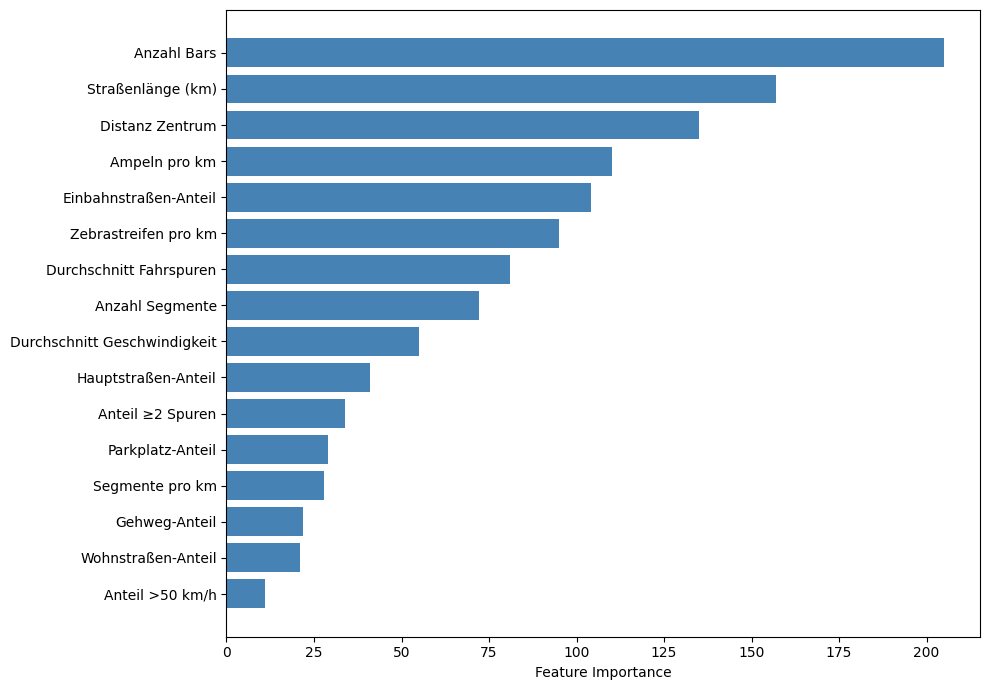

,Feature,Feature_DE,Anteil
0,bar_count,Anzahl Bars,17.1
1,road_km,Straßenlänge (km),13.1
4,dist_center,Distanz Zentrum,11.2
11,signals_per_roadkm,Ampeln pro km,9.2
13,oneway_km_share,Einbahnstraßen-Anteil,8.7
12,crossings_per_roadkm,Zebrastreifen pro km,7.9
9,lanes_mean_weighted,Durchschnitt Fahrspuren,6.8
2,segments_count,Anzahl Segmente,6.0
7,maxspeed_mean_weighted,Durchschnitt Geschwindigkeit,4.6
5,major_road_km_share,Hauptstraßen-Anteil,3.4


In [14]:
importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=True)

importance["Feature_DE"] = importance["Feature"].map(feature_names_de).fillna(importance["Feature"])
total_imp = importance["Importance"].sum()
importance["Anteil"] = (importance["Importance"] / total_imp * 100).round(1)

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(importance["Feature_DE"], importance["Importance"], color="steelblue")
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

importance.sort_values("Importance", ascending=False)[["Feature", "Feature_DE", "Anteil"]]

Straßenlänge und Distanz zum Zentrum dominieren – das Modell lernt vor allem über Exposition und Lage. Bar-Count hat Einfluss, ist aber nicht der stärkste Treiber.

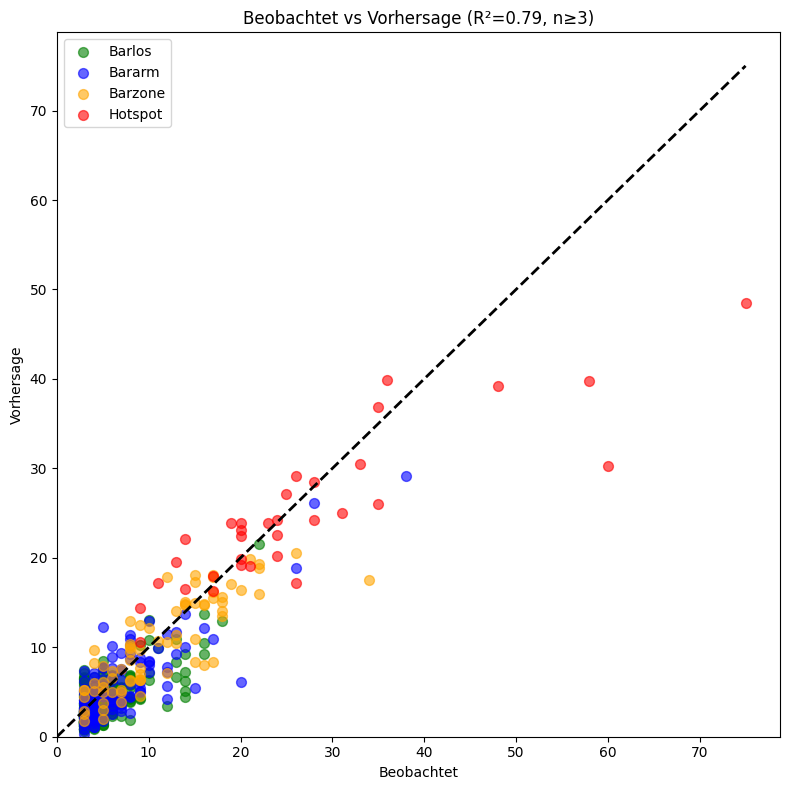

In [15]:
# Nur Grids mit min. 3 Unfällen
plot_data = df[df[target] >= 3].copy()

fig, ax = plt.subplots(figsize=(8, 8))

colors_map = {"Barlos": "green", "Bararm": "blue", "Barzone": "orange", "Hotspot": "red"}
for zname in ["Barlos", "Bararm", "Barzone", "Hotspot"]:
    z = plot_data[plot_data["ZoneType_4"] == zname]
    if len(z) == 0:
        continue
    ax.scatter(z[target], z["predicted"], c=colors_map[zname], label=zname, alpha=0.6, s=50)

max_val = max(plot_data[target].max(), plot_data["predicted"].max())
ax.plot([0, max_val], [0, max_val], "k--", lw=2)

r2 = r2_score(plot_data[target], plot_data["predicted"])
ax.set_xlabel("Beobachtet")
ax.set_ylabel("Vorhersage")
ax.set_title(f"Beobachtet vs Vorhersage (R²={r2:.2f}, n≥3)")
ax.legend()
ax.set_xlim(0, max_val * 1.05)
ax.set_ylim(0, max_val * 1.05)
plt.tight_layout()
plt.show()

Modell unterschätzt vor allem in Hotspot-Grids (rot) – dort passiert systematisch mehr als erwartet. Barlose Grids (grün) streuen wenig.

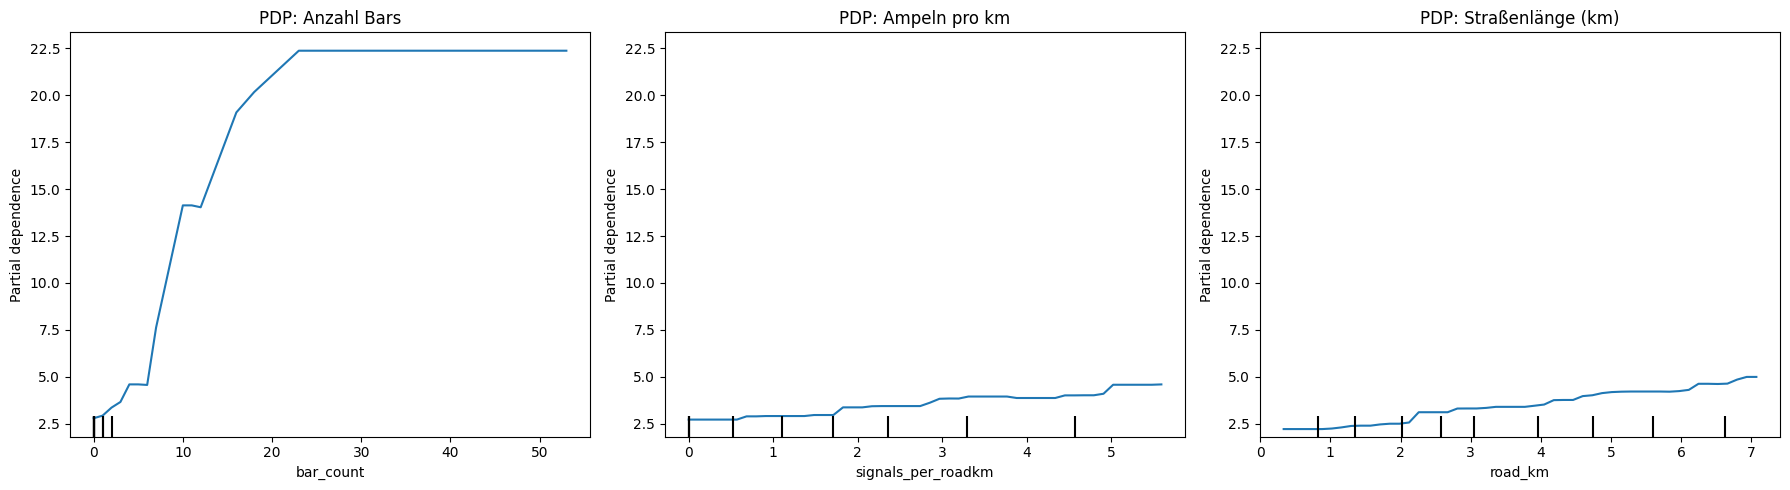

In [16]:
features_to_plot = ["bar_count", "signals_per_roadkm", "road_km"] # wichtigste Features aus Feature Importance

fig, ax = plt.subplots(1, len(features_to_plot), figsize=(18, 5))
PartialDependenceDisplay.from_estimator(model, X=X_test, features=features_to_plot, grid_resolution=50, ax=ax)
for i, f in enumerate(features_to_plot):
    ax[i].set_title(f"PDP: {feature_names_de.get(f, f)}")
plt.tight_layout()
plt.show()

Bar-Count zeigt einen klaren Knick ab ~5 Bars. Mehr Ampeln pro km korreliert mit mehr Unfällen (Proxy für Komplexität, nicht für Sicherheit).

In [17]:
feature_sets = {
    "full": features,
    "no_bars": [f for f in features if f != "bar_count"],
    "no_center": [f for f in features if f != "dist_center"],
    "no_exposure": [f for f in features if f not in ["road_km", "segments_count", "segments_per_roadkm"]],
    "no_intersections": [f for f in features if f not in ["signals_per_roadkm", "crossings_per_roadkm"]],
    "no_roadtype_speed_lanes": [f for f in features if f not in [
        "major_road_km_share", "residential_km_share",
        "maxspeed_mean_weighted", "maxspeed_share_over50",
        "lanes_mean_weighted", "lanes_share_ge2"
    ]],
    "no_rules_walk_park": [f for f in features if f not in ["oneway_km_share", "sidewalk_km_share", "parking_km_share"]],
}

fixed_params = model.get_params().copy() # gleiche Hyperparameter wie bestes Modell
fixed_params["verbose"] = -1

rows = []
for name, feats in feature_sets.items():
    m = lgb.LGBMRegressor(**fixed_params)
    m.fit(df.loc[train_idx, feats], y_train)
    p = np.clip(m.predict(df.loc[test_idx, feats]), 0, None)
    mt = compute_metrics(y_test, p)

    pred_all = np.clip(m.predict(df[feats]), 0, None)
    tmp = df[["GridID", target]].copy()
    tmp["_pred"] = pred_all
    rows.append({
        "setting": name, "n_features": len(feats),
        "test_MAE": round(mt["MAE"], 3), "test_RMSE": round(mt["RMSE"], 3), "test_R2": round(mt["R2"], 3),
        "overlap10": topk_overlap(tmp, target, "_pred", 10),
        "overlap20": topk_overlap(tmp, target, "_pred", 20),
    })

ablation = pd.DataFrame(rows)
full_rmse = float(ablation.loc[ablation.setting == "full", "test_RMSE"])
full_r2 = float(ablation.loc[ablation.setting == "full", "test_R2"])
ablation["delta_RMSE"] = (ablation["test_RMSE"] - full_rmse).round(3)
ablation["delta_R2"] = (ablation["test_R2"] - full_r2).round(3)

ablation.sort_values("test_RMSE")

,setting,n_features,test_MAE,test_RMSE,test_R2,overlap10,overlap20,delta_RMSE,delta_R2
2,no_center,15,1.896,3.494,0.757,9,15,-0.002,0.000
0,full,16,1.946,3.496,0.757,8,16,0.000,0.000
5,no_roadtype_speed_lanes,10,1.956,3.505,0.756,8,15,0.009,-0.001
4,no_intersections,14,1.991,3.561,0.748,8,15,0.065,-0.009
3,no_exposure,13,2.033,3.593,0.743,7,15,0.097,-0.014
6,no_rules_walk_park,13,1.949,3.629,0.738,8,16,0.133,-0.019
1,no_bars,15,2.174,4.434,0.609,6,14,0.938,-0.148


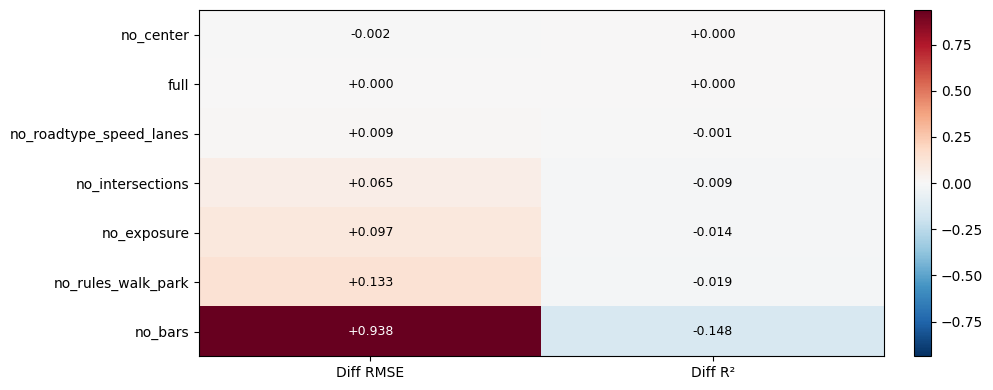

In [18]:
plot_df = ablation.set_index("setting")[["delta_RMSE", "delta_R2"]].sort_values("delta_RMSE")
vals = plot_df.values
m = float(np.nanmax(np.abs(vals))) if np.isfinite(vals).any() else 1.0

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(vals, aspect="auto", cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0, vmin=-m, vmax=m))  # 0 ist weiß, Verschlechterung rot, Verbesserung blau

ax.set_yticks(np.arange(len(plot_df)))
ax.set_yticklabels(plot_df.index)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Diff RMSE", "Diff R²"])

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        color = "white" if abs(vals[i, j]) > 0.6 * m else "black"
        ax.text(j, i, f"{vals[i, j]:+.3f}", ha="center", va="center", fontsize=9, color=color)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Ohne Exposure-features(road_km etc.) bricht das Modell am stärksten ein. Bars und Kreuzungs-featureshaben moderaten Einfluss.

### Export
- Parquets für das Deep-Dive-Notebook

In [19]:
df.to_parquet("grid_with_predictions.parquet", index=False)
uf_joined.to_parquet("unfaelle_with_grid.parquet", index=False)

print(f"grid_with_predictions.parquet: {len(df)} Zeilen")
print(f"unfaelle_with_grid.parquet: {len(uf_joined)} Zeilen")

grid_with_predictions.parquet: 1324 Zeilen
unfaelle_with_grid.parquet: 12488 Zeilen
